<a href="https://colab.research.google.com/github/SanyaMathur0411/Generative-AI/blob/main/Synthetic_image_Generation_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Generative Adversial Network


![GAN](https://raw.githubusercontent.com/106AbdulBasit/Kaggle-Projects/main/GAN/Genrative%20Adversial%20Networks.PNG)

There are two neural networks. One is Generator and the other is Discriminator
The Generator Network produces the images through the latent space vector. Then the discriminator network try to classify whether the image is real or fake. The process will last until the generator able to trick the discriminator in the training loop
In this tutorial, we will see how to implement the GAN in pytorch on CIFAR data set.


# Loading and Preprocessing the CIFAR-10 Dataset

## Dataset Overview
The **CIFAR-10** dataset consists of **60,000 color images** (32×32 pixels) across **10 classes**, with **50,000 training** and **10,000 test** images. It is commonly used for image classification and generative modeling.

## Preprocessing Steps
The dataset is loaded and preprocessed using `torchvision.datasets.CIFAR10`. The following transformations are applied:

1. **ToTensor()**:  
   - Converts the image from a PIL format to a PyTorch tensor.
   - Scales pixel values from `[0, 255]` to `[0, 1]`.

2. **Normalize(mean, std)**:  
   - Normalizes each color channel to have a mean of `0.5` and a standard deviation of `0.5`.
   - This transforms pixel values to the range `[-1, 1]`, which helps stabilize GAN training.



In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import CIFAR10

cifar = CIFAR10(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))]))

100%|██████████| 170M/170M [00:03<00:00, 43.9MB/s]


Extracting data/cifar-10-python.tar.gz to data


# Inspecting the CIFAR-10 Dataset

## Understanding the Dataset
After loading the CIFAR-10 dataset, it is essential to verify the preprocessing by inspecting individual images and their labels. This helps confirm that normalization and transformations were applied correctly.

## Expected Output and Explanation
1. **Label Verification**  
   - The dataset contains 10 classes, with labels ranging from `0` to `9`, each representing a specific category (e.g., airplane, automobile, bird, etc.).  
   - Printing the label ensures that the dataset is loaded correctly.

2. **Checking Pixel Values**  
   - A small region of the image is printed to verify that the transformation to a tensor was applied successfully.  
   - Since the images are normalized to the range `[-1, 1]` (using mean=0.5, std=0.5), the printed values should reflect this range.

3. **Min-Max Pixel Values**  
   - The minimum and maximum pixel values confirm that normalization was applied correctly.  
   - If the values fall within `[-1, 1]`, the dataset is properly preprocessed and ready for GAN training.



In [ ]:
img, label = cifar[0]
print('Label: ', label)
print(img[:,10:15,10:15])
print()
torch.min(img), torch.max(img)

Label:  6
tensor([[[-0.3725, -0.2392, -0.2941, -0.2314,  0.0745],
         [-0.1294,  0.1451,  0.0667,  0.2784,  0.3255],
         [ 0.0824,  0.6706,  0.3961,  0.4980,  0.6549],
         [ 0.2941,  0.7961,  0.4353,  0.4980,  0.8745],
         [ 0.5059,  0.4510,  0.1373,  0.5922,  0.7490]],

        [[-0.6863, -0.5843, -0.6471, -0.5608, -0.2863],
         [-0.5294, -0.3255, -0.3882, -0.0902, -0.0980],
         [-0.3804,  0.1765, -0.0353,  0.1765,  0.3255],
         [-0.1686,  0.3804,  0.0745,  0.2392,  0.6941],
         [ 0.1922,  0.1608, -0.2078,  0.2706,  0.5686]],

        [[-0.8980, -0.8667, -0.8667, -0.7647, -0.5529],
         [-0.8902, -0.8275, -0.8196, -0.3961, -0.4588],
         [-0.8510, -0.5373, -0.6784, -0.2314, -0.0431],
         [-0.6078, -0.2784, -0.5529, -0.1922,  0.3804],
         [-0.1137, -0.1608, -0.6000, -0.0510,  0.3333]]])



(tensor(-1.), tensor(1.))

# Denormalization Function

## Purpose
The CIFAR-10 dataset was normalized to the range **[-1, 1]** during preprocessing. However, when visualizing images, it is necessary to revert them to their original range **[0, 1]**. This function **denormalizes** the images to make them displayable.



In [ ]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

<span style="font-family:Times New Roman; font-size:18px;">  visualize some of the image </span>

Label: 6


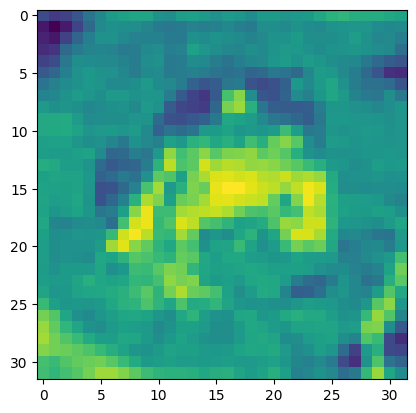

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0])
print('Label:', label)

In [ ]:
'''def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()'''

'def imshow(img):\n    img = img / 2 + 0.5     # unnormalize\n    npimg = img.numpy()\n    plt.imshow(np.transpose(npimg, (1, 2, 0)))\n    plt.show()'

# Creating a DataLoader for CIFAR-10

## Purpose
The **DataLoader** is used to efficiently load the CIFAR-10 dataset in batches, enabling smooth training of the **GAN model**. It helps with:
- **Batch processing**: Loads multiple images at once to speed up training.
- **Shuffling**: Ensures that each batch contains different images to improve model generalization.
- **Efficient memory usage**: Loads data dynamically, preventing memory overload.

## Key Parameters
1. **Batch Size (`batch_size=100`)**  
   - Defines the number of images in each batch.  
   - A larger batch size speeds up training but requires more memory.

2. **Shuffling (`shuffle=True`)**  
   - Randomizes the order of images in each epoch.  
   - Prevents the model from memorizing the order of training samples, improving generalization.


In [ ]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(cifar, batch_size, shuffle=True)

first batch
torch.Size([100, 3, 32, 32])
tensor([3, 8, 0, 0, 0, 9, 8, 5, 0, 9, 0, 5, 6, 2, 2, 9, 0, 7, 2, 1, 6, 9, 3, 2,
        1, 3, 5, 1, 3, 4, 6, 0, 9, 1, 7, 8, 3, 2, 9, 7, 2, 3, 9, 4, 9, 9, 0, 7,
        3, 0, 7, 3, 4, 6, 5, 6, 8, 3, 6, 8, 5, 5, 5, 2, 8, 5, 1, 3, 2, 4, 2, 7,
        7, 0, 0, 8, 2, 7, 8, 8, 7, 2, 8, 6, 4, 5, 6, 6, 1, 4, 3, 8, 8, 1, 7, 2,
        1, 8, 7, 7])


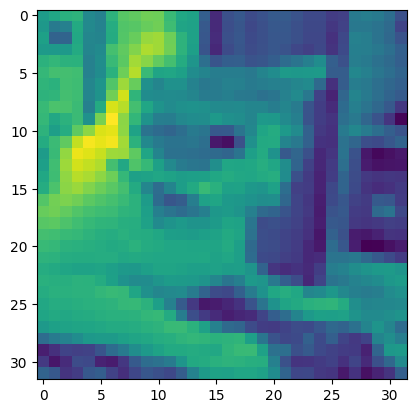

In [ ]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0])
    print(label_batch)
    break

<span style="font-family:Times New Roman; font-size:18px;">Check is the gpu is availabe </span>

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')



<span style="font-family:Times New Roman; font-size:18px;">We are setting the Image_ size to 3072 becuase  </span>

<span style="font-family:Times New Roman; font-size:18px;">Our Images size is 32 * 32 and it has 3 channels. </span>

<span style="font-family:Times New Roman; font-size:18px;">So 32 * 32 * 3 = 3072</span>

In [ ]:
image_size = 3072
hidden_size = 256

<h1  id="3" style="color:black;
           display:fill;
           border-radius:5px;
           background-color:#FFFFFF;
           font-size:350%;
           font-family:Times New Roman;
           letter-spacing:0.5px"> 3  Discriminator Network </h1>


<span style="font-family:Times New Roman; font-size:18px;">The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. While we can use a CNN for the discriminator, we'll use a simple feedforward network with 3 linear layers to keep things since</span>


In [ ]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [ ]:
print(D)

Sequential(
  (0): Linear(in_features=3072, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)


In [ ]:
D.to(device);

In [ ]:
latent_size = 64

<h1  id="4" style="color:black;
           display:fill;
           border-radius:5px;
           background-color:#FFFFFF;
           font-size:350%;
           font-family:Times New Roman;
           letter-spacing:0.5px"> 4 Generator Network </h1>

<span style="font-family:Times New Roman; font-size:18px;">The input to the generator is typically a vector or a matrix which is used as a seed for generating an image. Once again, to keep things simple, we'll use a feedfoward neural network with 3 layers </span>

In [ ]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [ ]:
y = G(torch.randn(2, latent_size))
y.shape

torch.Size([2, 3072])

In [ ]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 32,32)).detach())

<span style="font-family:Times New Roman; font-size:18px;">Show some Genrated Images </span>

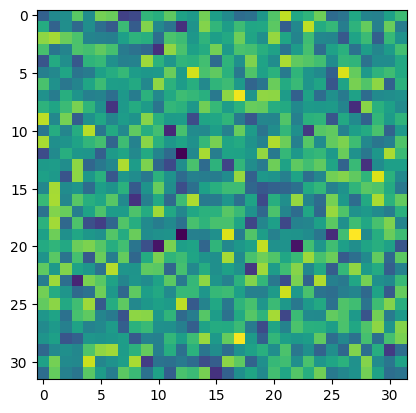

In [ ]:
plt.imshow(gen_imgs[0]);

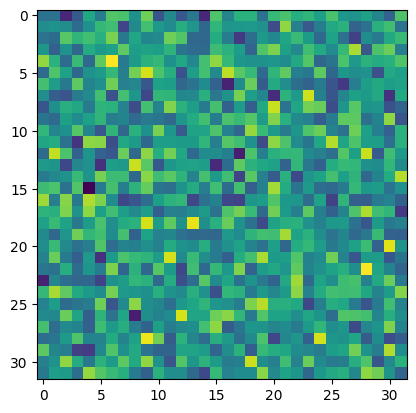

In [ ]:
plt.imshow(gen_imgs[1]);


In [ ]:
G.to(device);

# Loss Function and Optimizers  

## Loss Function  
- **Binary Cross-Entropy Loss (BCELoss)**:  
  Used for both the Generator and Discriminator. Measures how well the model differentiates between real and fake images.

## Optimizers  
- **Adam Optimizer**:  
  - **Discriminator (`d_optimizer`)** and **Generator (`g_optimizer`)** are both optimized using Adam with a learning rate of **0.0002**.  
  - Adam is chosen for its efficiency in training GANs, with adaptive learning rates.

## Importance  
- **BCELoss** helps guide the models to generate realistic images.
- **Adam Optimizer** ensures stable and efficient training of both networks.  



In [ ]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

# Training the Discriminator

## Purpose
The function trains the **Discriminator (D)** of the GAN by updating its weights to better distinguish between real and fake images.

## Key Steps  
1. **Real Images Loss**  
   - The Discriminator is fed real images and the corresponding labels (`real_labels`).  
   - The loss is calculated using **Binary Cross-Entropy (BCE)**.

2. **Fake Images Loss**  
   - The Generator creates fake images from random noise (`z`), which are passed to the Discriminator.  
   - The loss is computed with fake labels (`fake_labels`).

3. **Combining Losses**  
   - The total loss is the sum of the real and fake image losses, guiding the Discriminator to improve its classification.

4. **Backpropagation**  
   - Gradients are reset, calculated, and used to update the Discriminator’s parameters.



In [ ]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

# Training the Generator

## Purpose
The function trains the **Generator (G)** to improve its ability to create realistic images that can fool the Discriminator.

## Key Steps  
1. **Generate Fake Images**  
   - Random noise (`z`) is passed through the Generator to create fake images.

2. **Loss Calculation**  
   - The Discriminator evaluates the fake images, and the loss is calculated using **Binary Cross-Entropy (BCE)** with **real labels** (since the Generator aims to make the images appear real).

3. **Backpropagation and Optimization**  
   - Gradients are reset, computed, and used to update the Generator’s weights.




In [ ]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

<h1  id="7" style="color:black;
           display:fill;
           border-radius:5px;
           background-color:#FFFFFF;
           font-size:350%;
           font-family:Times New Roman;
           letter-spacing:0.5px"> Training The Model </h1>

In [ ]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

<span style="font-family:Times New Roman; font-size:18px;">Save The Batch of Real Images </span>

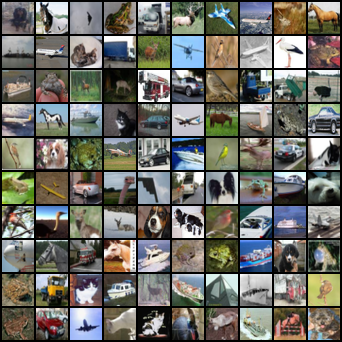

In [ ]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 3, 32, 32)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

<span style="font-family:Times New Roman; font-size:18px;">We'll also define a helper function to save a batch of generated images to disk at the end of every epoch. We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. </span>

Saving fake_images-0000.png


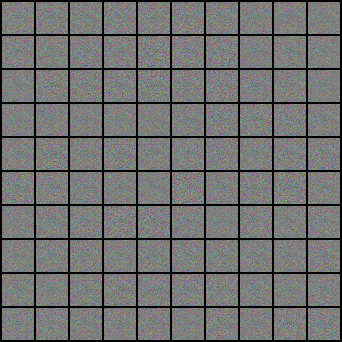

In [ ]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 32, 32)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

# Training the GAN Model

## Purpose  
This section trains the **Discriminator** and **Generator** over multiple epochs, updating their parameters iteratively to improve the generated images.

## Key Steps  
1. **Epoch Loop**  
   - The training process runs for a specified number of epochs (`num_epochs`), iterating over the entire dataset.

2. **Batch Processing**  
   - Each batch of images is reshaped and passed through the **Discriminator** and **Generator**.
   - The **Discriminator** is trained to classify real and fake images, and the **Generator** is trained to generate fake images that appear real.

3. **Loss Tracking**  
   - After every 200 steps, the **Discriminator loss** (`d_loss`), **Generator loss** (`g_loss`), **real image score** (`D(x)`), and **fake image score** (`D(G(z))`) are printed for monitoring training progress.

4. **Save Generated Images**  
   - At the end of each epoch, generated images are saved for inspection to track the improvement in quality.




In [ ]:
%%time

num_epochs = 10
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size,-1).to(device)


        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/10], Step [200/500], d_loss: 0.1345, g_loss: 5.2693, D(x): 0.93, D(G(z)): 0.05
Epoch [0/10], Step [400/500], d_loss: 0.0542, g_loss: 6.3389, D(x): 0.99, D(G(z)): 0.03
Saving fake_images-0001.png
Epoch [1/10], Step [200/500], d_loss: 0.0194, g_loss: 6.1500, D(x): 1.00, D(G(z)): 0.02
Epoch [1/10], Step [400/500], d_loss: 0.0291, g_loss: 4.2811, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0002.png
Epoch [2/10], Step [200/500], d_loss: 0.0108, g_loss: 6.0768, D(x): 1.00, D(G(z)): 0.01
Epoch [2/10], Step [400/500], d_loss: 0.0223, g_loss: 4.3788, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0003.png
Epoch [3/10], Step [200/500], d_loss: 0.0237, g_loss: 7.4532, D(x): 0.99, D(G(z)): 0.00
Epoch [3/10], Step [400/500], d_loss: 0.0959, g_loss: 8.5498, D(x): 0.98, D(G(z)): 0.01
Saving fake_images-0004.png
Epoch [4/10], Step [200/500], d_loss: 0.0165, g_loss: 8.9196, D(x): 1.00, D(G(z)): 0.02
Epoch [4/10], Step [400/500], d_loss: 0.0273, g_loss: 8.6666, D(x): 0.99, D(G(z)): 0.00
Saving f

In [ ]:
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

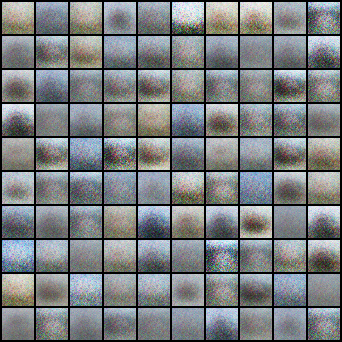

In [ ]:
Image('./samples/fake_images-0010.png')

# Saving and Visualizing Generated Images

## Purpose  
This section handles saving the generated images as a video file to visualize the progress of the **GAN training** over time.

## Key Steps  
1. **File Collection**  
   - A list of files containing generated images is gathered from a directory (`sample_dir`) where the images are stored. The filenames are filtered to include only those that contain 'fake_images'.

2. **Sorting Files**  
   - The files are sorted in order to ensure the frames appear sequentially in the video.





# Visualizing the Losses

## Purpose  
This section plots the training losses of the **Discriminator** and **Generator** over epochs to track their progress during GAN training.

## **Loss Plotting**  
   - The **Discriminator losses** (`d_losses`) and **Generator losses** (`g_losses`) are plotted against epochs.
   - The x-axis represents the epoch number, and the y-axis shows the loss value.




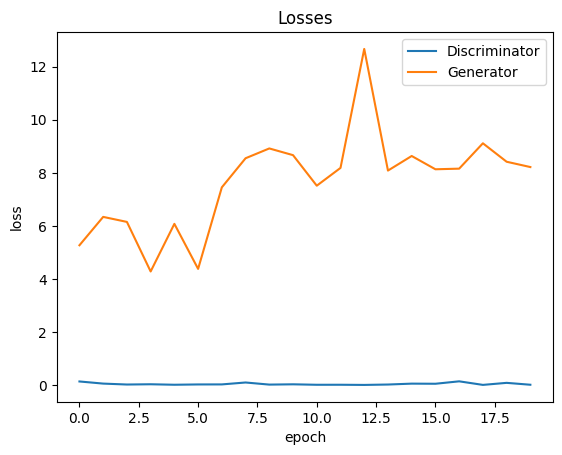

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

# Visualizing the Scores

## Purpose  
This section plots the **Real** and **Fake scores** over epochs to track the performance of the **Discriminator** in distinguishing between real and generated images.

## **Score Plotting**  
   - The **real scores** (`real_scores`) and **fake scores** (`fake_scores`) are plotted against epochs.
   - The x-axis represents the epoch number, and the y-axis shows the score given by the Discriminator for real and fake images.



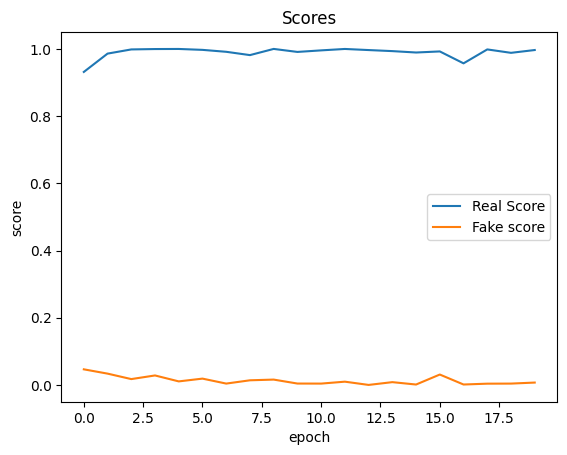

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');